In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import time

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.inspection import plot_partial_dependence
from scipy.stats import spearmanr
from scipy.cluster import hierarchy
from sklearn.decomposition import PCA
import shap

Read in label/unlabel df created in inspire_eda 

In [2]:
df = pd.read_csv('df_final.csv')
df_nolabel = pd.read_csv('df_nolabel.csv')

# remove author name in labelled data
df.drop('Unnamed: 0', axis=1, inplace=True)

# keep author name in unlabelled data
df_nolabel.set_index(df_nolabel['Unnamed: 0'], inplace=True)
df_nolabel.drop('Unnamed: 0', axis=1, inplace=True)

df.head()

,Num_authors_mean,cpy_max,cpy_mean,Productivity,collab_cpy_mean_mean,collab_cpy_mean_max,collab_cpy_max_mean,collab_cpy_max_max,Label
0,1.096154,99.604167,7.035821,3.250000,4.113859,7.362778,51.224900,173.105263,Active
1,2.000000,0.428571,0.307143,1.333333,0.557216,0.557216,5.142857,5.142857,Churn
2,3.875000,6.800000,0.917031,1.263158,1.422363,5.295698,10.267004,155.208333,Active
3,4.666667,2.153846,1.041958,1.000000,1.240559,1.912698,5.930101,14.230769,Churn
4,2.666667,0.375000,0.125000,0.750000,1.113455,1.328073,12.986111,26.375000,Churn


### Create predictors and target

In [5]:
features = ['Num_authors_mean',
     'cpy_max',
     'cpy_mean',
     'Productivity',
     'collab_cpy_mean_mean',
     'collab_cpy_mean_max',
     'collab_cpy_max_mean',
     'collab_cpy_max_max']
X = df[features]
X_nolabel = df_nolabel[features]
y = np.where(df.Label == 'Active', 1, 0)

### Feature importance is misleading due to high correlation between features

Feature ranking:
feature cpy_max (0.192663)
feature collab_cpy_mean_max (0.158753)
feature collab_cpy_max_max (0.153463)
feature Productivity (0.110918)
feature collab_cpy_max_mean (0.108232)
feature collab_cpy_mean_mean (0.103540)
feature cpy_mean (0.096038)
feature Num_authors_mean (0.076393)


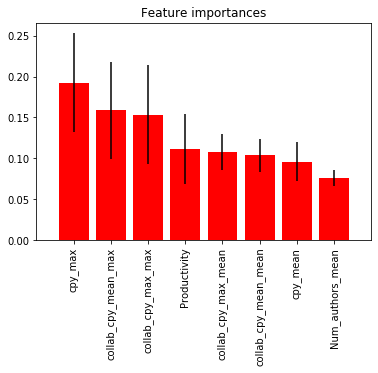

In [6]:
forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=0)
forest.fit(X, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
test = [features[f] for f in indices]
for f in range(X.shape[1]):
    print("feature %s (%f)" % (test[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), test, rotation='vertical')
plt.xlim([-1, X.shape[1]])
plt.show()

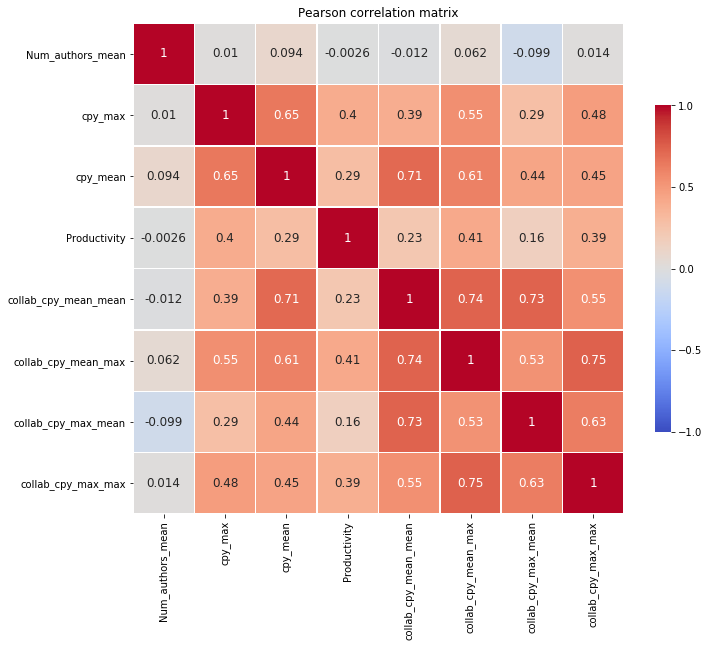

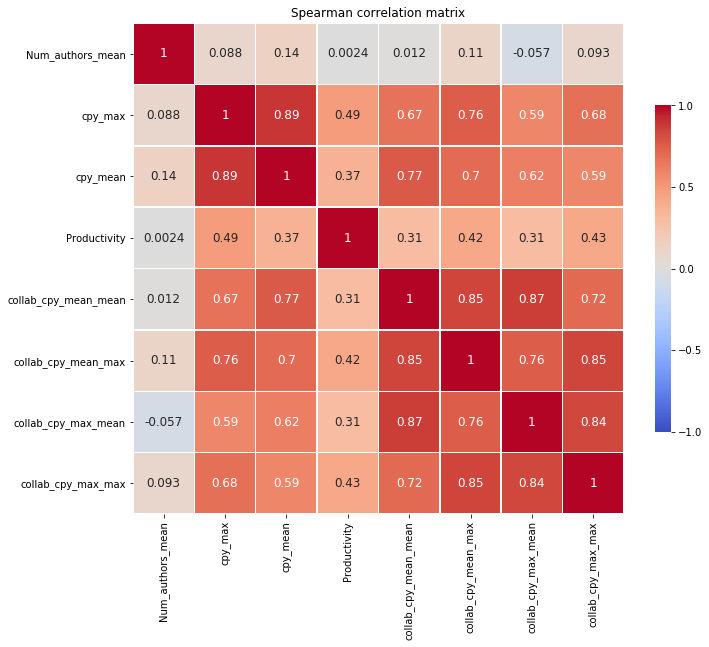

In [58]:
# Pearson, Spearman Correlation matrix

fig, ax1 = plt.subplots(figsize=(11, 15)) 

pearson_corr = X.corr()
spearman_corr = pd.DataFrame(spearmanr(X).correlation, index=features, columns=features)

# Create heatmaps
pearson_heatmap = sns.heatmap(pearson_corr,
                     square = True,
                      linewidths = .5,
                      cmap = 'coolwarm',
                      cbar_kws = {'shrink': .4, 
                                'ticks' : [-1, -.5, 0, 0.5, 1]},
                      vmin = -1, 
                      vmax = 1,
                      annot = True,
                      annot_kws = {'size': 12})
ax1.set_yticklabels(pearson_corr.columns, rotation = 0)
ax1.set_xticklabels(pearson_corr.columns)
ax1.set_title('Pearson correlation matrix')
sns.set_style({'xtick.bottom': True}, {'ytick.left': True})


fig, ax2 = plt.subplots(figsize=(11, 15)) 

spearman_heatmap = sns.heatmap(spearman_corr,
                     square = True,
                      linewidths = .5,
                      cmap = 'coolwarm',
                      cbar_kws = {'shrink': .4, 
                                'ticks' : [-1, -.5, 0, 0.5, 1]},
                      vmin = -1, 
                      vmax = 1,
                      annot = True,
                      annot_kws = {'size': 12})
ax2.set_yticklabels(spearman_corr.columns, rotation = 0)
ax2.set_xticklabels(spearman_corr.columns)
ax2.set_title('Spearman correlation matrix')
sns.set_style({'xtick.bottom': True}, {'ytick.left': True})


### Model Selection and Diagnosis

In [53]:
def score_CV(model, metric):
    score = cross_val_score(model, X, y, cv=5, scoring=metric)
    print(metric, score)
    print(metric, 'mean:', np.mean(score))

In [54]:
# First try simple logistic regression model
logreg = LogisticRegression(solver='newton-cg', C=0.5)
score_CV(logreg, 'accuracy')
score_CV(logreg, 'roc_auc')

accuracy [0.83729829 0.84328731 0.83494176 0.84159734 0.84442596]
accuracy mean: 0.8403101302631255
roc_auc [0.91818073 0.91956072 0.91858481 0.91747457 0.9183647 ]
roc_auc mean: 0.9184331052659018


In [55]:
# Try a standard Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, random_state=0)
score_CV(rf, 'accuracy')
score_CV(rf, 'roc_auc')

accuracy [0.8724006  0.88138413 0.87803661 0.88202995 0.88502496]
accuracy mean: 0.8797752484283528
roc_auc [0.94903716 0.95365501 0.95090056 0.95221865 0.95670526]
roc_auc mean: 0.9525033293798248


In [ ]:
# Fancier Adaboost Classifier only gives 0.01 increase in CV scores
#boost = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3), n_estimators=50, random_state=0)
#score_CV(boost, 'accuracy')
#score_CV(boost, 'roc_auc')

### Clustering to visualize most correlated features

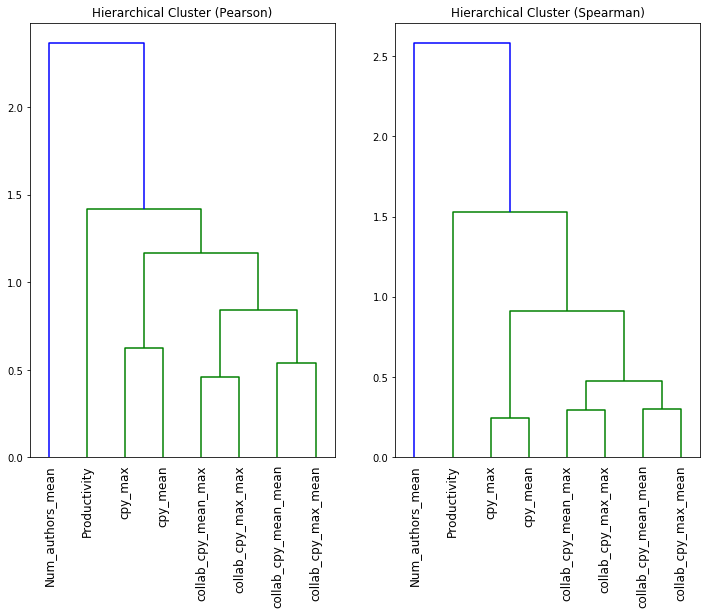

In [63]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

corr_linkage1 = hierarchy.ward(X.corr())
dendro1 = hierarchy.dendrogram(corr_linkage1, labels=features, ax=ax1,
                              leaf_rotation=90)
dendro1_idx = np.arange(0, len(dendro1['ivl']))

corr_linkage2 = hierarchy.ward(spearmanr(X).correlation)
dendro2 = hierarchy.dendrogram(corr_linkage2, labels=features, ax=ax2,
                              leaf_rotation=90)
dendro2_idx = np.arange(0, len(dendro2['ivl']))
ax1.set_title('Hierarchical Cluster (Pearson)')
ax2.set_title('Hierarchical Cluster (Spearman)')

plt.show()

PDP for least correlated (though not very important) features {Num_authors_mean, Productivity}

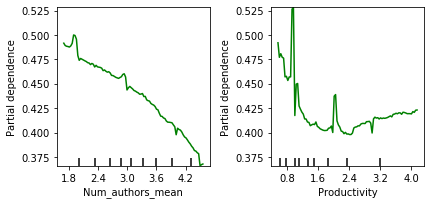

In [72]:
rf.fit(X, y)
plot_partial_dependence(rf, X, ['Num_authors_mean', 'Productivity'], features)

Train model on subset of clustered features - not much difference in CV scores

In [180]:
featuresub = ['Num_authors_mean',
              'Productivity',
              'cpy_max',
              'cpy_mean',
              'collab_cpy_mean_mean',
              'collab_cpy_max_max']
Xsub = X[featuresub]
rf = RandomForestClassifier(n_estimators=100, random_state=0)
score_acc = cross_val_score(rf, Xsub, y, cv=5, scoring='accuracy')
score_roc = cross_val_score(rf, Xsub, y, cv=5, scoring='roc_auc')
print('accuracy', score_acc)
print('roc_auc', score_roc)

accuracy [0.85493262 0.86175345 0.86006656 0.86489185 0.86805324]
roc_auc [0.93262188 0.93724721 0.93649048 0.93792043 0.94421805]


Try PCA to diagonlize correlation matrix, find three most important eigenvectors. 
Slight reduction in CV scores

In [77]:
pca = PCA()
pca.fit(X)
print('PCA top 3:', pca.explained_variance_ratio_[:3])
pca = PCA(n_components=3)
Xpca = pd.DataFrame(pca.fit_transform(X))

rf = RandomForestClassifier(n_estimators=100, random_state=0)
score_acc = cross_val_score(rf, Xpca, y, cv=5, scoring='accuracy')
score_roc = cross_val_score(rf, Xpca, y, cv=5, scoring='roc_auc')
print('accuracy', score_acc)
print('roc_auc', score_roc)

PCA top 3: [0.94370985 0.0357255  0.01931906]
accuracy [0.82914656 0.82831476 0.82778702 0.83577371 0.83460899]
roc_auc [0.90118907 0.90106404 0.8983463  0.89982348 0.9070326 ]


### Fit Random Forest Classifier to full labeled dataset

In [7]:
rf = RandomForestClassifier(n_estimators=100, random_state=0)
model = rf.fit(X, y)

### Define function to print predictions on unlabeled test sample and return SHAP explanation plot

In [8]:
def explain_name(name):
    data = X_nolabel.loc[name]
    print(data)
    testname = np.array(data).reshape(1, -1)
    predname = model.predict_proba(testname)
    print('Churn prediction:', predname[0])
    
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(data)
    shap.initjs()
    shapeplot = shap.force_plot(explainer.expected_value[1], shap_values[1], data)
    return shapeplot

### Model does not seem to work well for grad students (gives very low predictions)!

In [13]:
explain_name('Narayan, V.')

Num_authors_mean         3.750000
cpy_max                  7.000000
cpy_mean                 5.208333
Productivity             2.000000
collab_cpy_mean_mean     5.267335
collab_cpy_mean_max      8.746484
collab_cpy_max_mean     29.597222
collab_cpy_max_max      56.333333
Name: Narayan, V., dtype: float64
Churn prediction: [0.97 0.03]


Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [14]:
explain_name('Dunsky, D.')

Num_authors_mean         3.000000
cpy_max                  4.666667
cpy_mean                 3.388889
Productivity             1.500000
collab_cpy_mean_mean     4.315734
collab_cpy_mean_max      5.025046
collab_cpy_max_mean     48.450000
collab_cpy_max_max      56.900000
Name: Dunsky, D., dtype: float64
Churn prediction: [1. 0.]


Setting feature_perturbation = "tree_path_dependent" because no background data was given.


### Model does appear accurate for known postdoc candidates - perhaps due to more reliable metrics or more similar examples in the training data!

In [15]:
explain_name('Dror, J.')

Num_authors_mean         3.444444
cpy_max                 12.250000
cpy_mean                 4.131019
Productivity             2.571429
collab_cpy_mean_mean     4.924761
collab_cpy_mean_max      9.125430
collab_cpy_max_mean     25.703801
collab_cpy_max_max      62.695652
Name: Dror, J., dtype: float64
Churn prediction: [0.43 0.57]


Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [16]:
explain_name('Bao, N.')

Num_authors_mean          3.045455
cpy_max                  15.166667
cpy_mean                  2.947285
Productivity              4.888889
collab_cpy_mean_mean      4.454754
collab_cpy_mean_max      17.603175
collab_cpy_max_mean      35.593611
collab_cpy_max_max      211.727273
Name: Bao, N., dtype: float64
Churn prediction: [0.09 0.91]


Setting feature_perturbation = "tree_path_dependent" because no background data was given.
